# Task 1

Authors:

Joanna Działo 148260

Wojciech Majewski 148253 

## Task description and imports

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

Importing all needed libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import copy
from tensorflow import keras
from keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, Masking, Dropout, GlobalMaxPool1D
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score
from numpy.lib.stride_tricks import sliding_window_view

Dataset generation:

In [2]:
np.random.seed(42)

In [3]:
n = 50000   #there are 50000 sets of 3 series of different lengths

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

At first we tried an approach where we tried to "cut" the time-series up to the lowest length, but we clearly left that idea, as an anomaly might've occured on the part we cut. Instead we decided on zero padding from the Keras library. This way no information was lost from the time series and the length was same.

In [5]:
xl, yl, lenghts = [], [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    row = createRow(np.random.randint(40,60), cl)
    xl.append(row)
    lenghts.append(len(row))
    yl.append(cl)
print(lenghts)

[58, 51, 59, 41, 47, 57, 57, 41, 59, 50, 52, 54, 41, 54, 42, 54, 46, 44, 52, 49, 58, 51, 54, 49, 46, 40, 42, 53, 48, 45, 54, 47, 43, 54, 47, 40, 48, 51, 44, 47, 59, 47, 43, 42, 44, 48, 43, 46, 43, 40, 51, 45, 44, 51, 51, 55, 43, 58, 52, 42, 52, 57, 50, 56, 49, 49, 50, 55, 42, 57, 53, 56, 54, 45, 40, 50, 55, 49, 46, 59, 50, 53, 42, 48, 45, 48, 44, 55, 58, 58, 57, 55, 59, 50, 54, 58, 51, 58, 46, 49, 55, 59, 43, 41, 57, 40, 45, 51, 45, 41, 56, 46, 58, 58, 57, 58, 50, 50, 41, 49, 41, 41, 58, 51, 42, 54, 45, 54, 55, 52, 49, 53, 53, 50, 41, 54, 49, 40, 42, 53, 49, 50, 44, 55, 43, 57, 46, 44, 41, 56, 53, 42, 47, 55, 50, 46, 48, 51, 58, 42, 43, 56, 58, 59, 54, 49, 56, 52, 50, 46, 52, 54, 59, 58, 53, 47, 53, 58, 59, 48, 55, 59, 50, 46, 51, 44, 56, 53, 47, 49, 53, 43, 57, 53, 42, 59, 50, 51, 58, 50, 44, 46, 54, 59, 46, 59, 43, 47, 59, 42, 58, 57, 48, 46, 52, 52, 42, 59, 44, 55, 58, 57, 58, 43, 43, 45, 49, 49, 56, 49, 54, 57, 46, 41, 56, 53, 44, 51, 51, 42, 59, 53, 56, 58, 57, 42, 43, 45, 41, 55,

[False False False False  True]


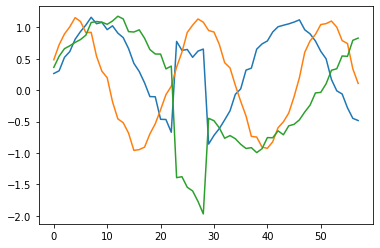

[False False False  True  True]


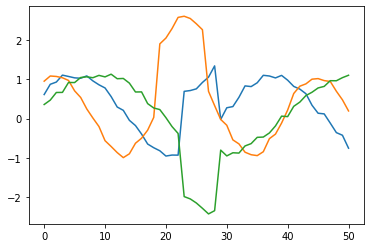

[False False False False False]


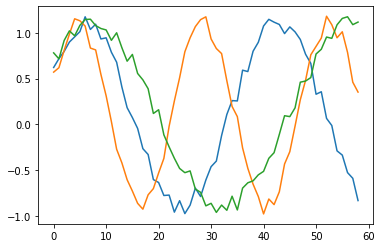

[ True False False False  True]


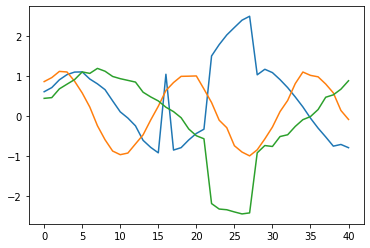

[False  True False False False]


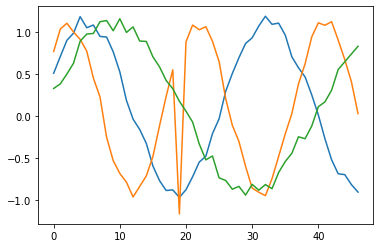

[False False False False False]


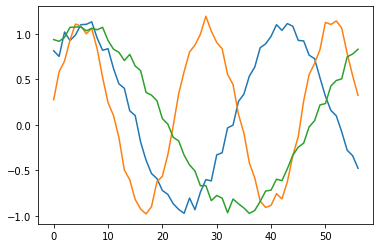

In [6]:
for i in range(6):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

## Preprocessing

As mentioned before, first we decided to tackle the problem of not equal length data. For that we used the built-in function of keras preprocessing. This function pads all series with 0s to the make the range equal for all cases.

In [7]:
padded_x = tf.keras.preprocessing.sequence.pad_sequences(xl, padding="post", dtype="float32")
x = tf.convert_to_tensor(padded_x, dtype=tf.float32)
yl = [element.astype(np.float32) for element in yl]
y = tf.convert_to_tensor(yl, dtype=tf.float32)
x.shape, y.shape

(TensorShape([50000, 59, 3]), TensorShape([50000, 5]))

Visualization of the padded sequences:

tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


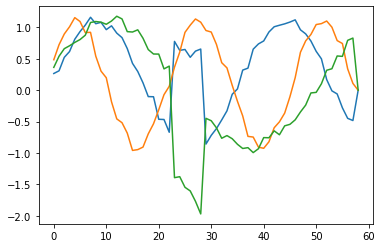

tf.Tensor([0. 0. 0. 1. 1.], shape=(5,), dtype=float32)


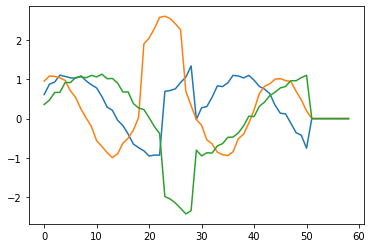

tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


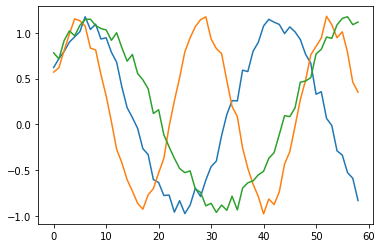

tf.Tensor([1. 0. 0. 0. 1.], shape=(5,), dtype=float32)


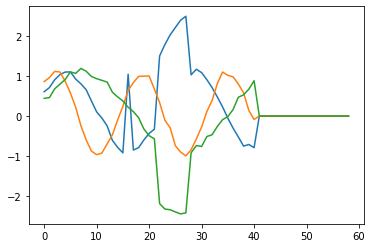

tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


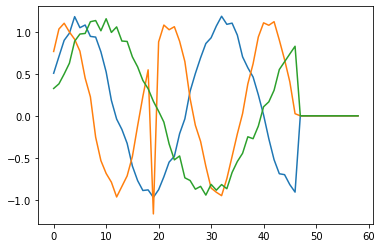

tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


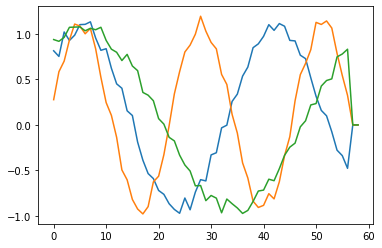

In [8]:
for i in range(6):
    plt.plot(x[i])
    print(y[i])
    plt.show()

This is not a perfect solution - we could've generated the sequence, but this one allowed us to focus on training faster.

Here's a random idea that we had - the data was really all around the place so we decided to "normalize" it. We want to find anomalies - points which skew from their surroundings. Our "normalizing_function" assigns the value of each point in the timeseries to the mean of absolute differences of it's two closest neighbours.

tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


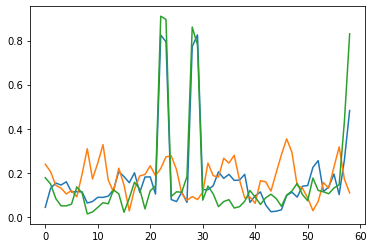

tf.Tensor([0. 0. 0. 1. 1.], shape=(5,), dtype=float32)


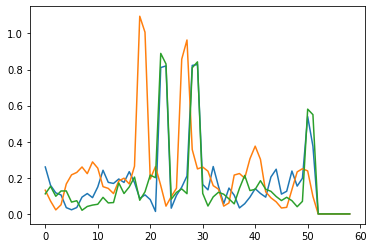

tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


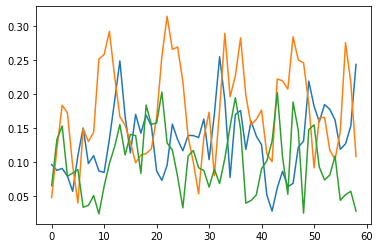

tf.Tensor([1. 0. 0. 0. 1.], shape=(5,), dtype=float32)


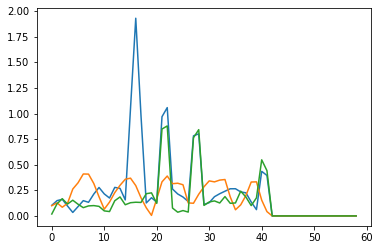

tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


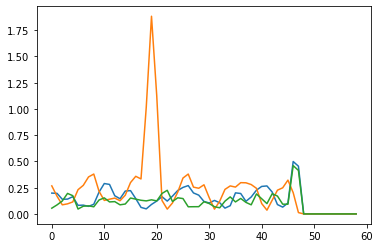

tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


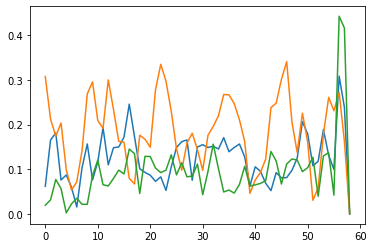

In [9]:
def normalizing_function(data):
    transformed_data = copy.deepcopy(data)
    for serie_index in range(len(data)):
        copy_current_serie = copy.deepcopy(data[serie_index])
        #the first and last elements only have one neighbour, so we set them outside of the for loop
        copy_current_serie[0] = abs(data[serie_index][0] - data[serie_index][1])
        copy_current_serie[len(data[serie_index]) - 1] = abs(data[serie_index][len(data[serie_index]) - 1] - data[serie_index][len(data[serie_index]) - 2])
        for index in range(1, len(data[serie_index]) - 1):
            before_current = data[serie_index][index - 1]
            current = data[serie_index][index]
            after_current = data[serie_index][index + 1]
            copy_current_serie[index] = (abs(current - before_current) + abs(current - after_current))/2
        transformed_data[serie_index] = copy_current_serie
    return transformed_data
transformed_x = normalizing_function(padded_x)
for i in range(6):
    plt.plot(transformed_x[i])
    print(y[i])
    plt.show()

We got the idea for using sliding window algorithm from here: https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a

We ended up implementing it and using it differenty, but the idea stuck. Before using sliding windows we used "repeat vectors" for the TimeDistributed part to work, but this proved to work much better.

In [10]:
def sliding_window(data, win_size=15):
    returned_data = []
    for i in range(data.shape[0]):
        serie_a = sliding_window_view(data[i, :, 0], win_size)
        serie_b = sliding_window_view(data[i, :, 1], win_size)
        serie_c = sliding_window_view(data[i, :, 2], win_size)
        window = []
        for index in range(len(serie_a)):
            window.append(np.column_stack((serie_a[index], serie_b[index], serie_c[index])))
        returned_data.append(window)
    return np.array(returned_data)
slided_windows = sliding_window(transformed_x)

Splitting our transformed dataset into 3 sets - train, test valid in the ratio 77.7%/16.6%/16.6%

In [11]:
x_train, y_train, x_test, y_test, x_valid, y_valid = slided_windows[:35000], y[:35000],  slided_windows[35000:42500], y[35000:42500],  slided_windows[42500:], y[42500:]
x_train.shape

(35000, 45, 15, 3)

## Final model and predictions

Here's our final model - it actually consits of two models, because using just and LSTM inside the TimeDistributed layer didn't work and we knew that LSTMs are the best way to handle Time Series. First we declare the input shape - 45, 15, 3 (after doing the sliding window algorithm) then we use TimeDistributed in which there is another model with an LSTM and a Dense layer with sigmoid activation (sigmoid to make the probabilities of belonging to each class from 0 to 1) and then a GlobalMaxPool to MaxPool the windows. The optimizer is adam, loss function binary_crossentropy and the main metric binary_accuracy (because it's a multiclass problem of belonging to a class). The result is a vector of 5 float probabilities of belonging to the given class.

In [12]:
model = Sequential()
model.add(Input(shape=(45, 15, 3)))
model.add(TimeDistributed(Sequential([
        Input(shape=(15, 3)),
        LSTM(10),
        Dense(y_train.shape[1], 'sigmoid')
    ])
))
model.add(GlobalMaxPool1D())
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', tf.keras.metrics.Recall(thresholds=0), tf.keras.metrics.Precision(thresholds=0)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 45, 5)            615       
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 615
Trainable params: 615
Non-trainable params: 0
_________________________________________________________________


Here we fit our model using batch size 512 and number of epochs 50 (the model kept learning so we expanded from the initial 10 and 30 epochs)

In [13]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size=512, 
    epochs=50, 
    validation_data=(x_valid, y_valid)
)

Epoch 1/50
69/69 [==============================] - 14s 165ms/step - loss: 0.6727 - binary_accuracy: 0.6459 - recall: 1.0000 - precision: 0.2515 - val_loss: 0.6145 - val_binary_accuracy: 0.7516 - val_recall: 1.0000 - val_precision: 0.2484
Epoch 2/50
69/69 [==============================] - 11s 158ms/step - loss: 0.5797 - binary_accuracy: 0.7485 - recall: 1.0000 - precision: 0.2515 - val_loss: 0.5618 - val_binary_accuracy: 0.7516 - val_recall: 1.0000 - val_precision: 0.2484
Epoch 3/50
69/69 [==============================] - 11s 166ms/step - loss: 0.5629 - binary_accuracy: 0.7485 - recall: 1.0000 - precision: 0.2515 - val_loss: 0.5577 - val_binary_accuracy: 0.7516 - val_recall: 1.0000 - val_precision: 0.2484
Epoch 4/50
69/69 [==============================] - 12s 175ms/step - loss: 0.5581 - binary_accuracy: 0.7485 - recall: 1.0000 - precision: 0.2515 - val_loss: 0.5502 - val_binary_accuracy: 0.7516 - val_recall: 1.0000 - val_precision: 0.2484
Epoch 5/50
69/69 [==========================

After 50 epochs our final binary accuracy is 98% and loss is 6%

Here are plots of the loss and accuracy functions changing through the epochs - it's clearly visible that the model learned beautifully.

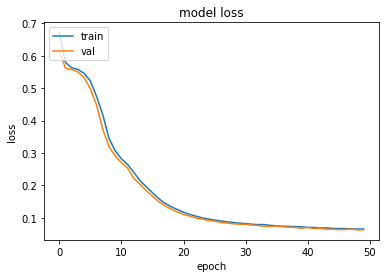

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

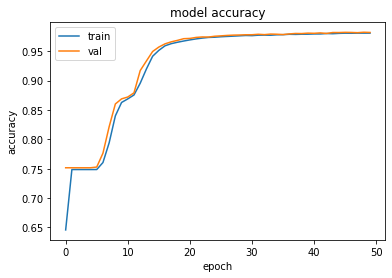

In [15]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Here are the generated predictions - clearly all are correct :)

In [16]:
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print(tf.convert_to_tensor((predictions > 0.5) * 1, dtype=tf.float32))
print(y_test[:3])

Generate predictions for 3 samples
1/1 [==============================] - 1s 803ms/step
tf.Tensor(
[[1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]], shape=(3, 5), dtype=float32)


And that's all from us. Sadly we didn't manage to complete the second task, although we gave it a fair try. Our predictive model clearly states whether a given candy has a defect and of which type with a 98% accuracy.

